In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib import animation
from scipy import interpolate, signal, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [7]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [8]:
area_colors = {
    'MO': 'blue', # [31, 157, 90]
    'ACA': 'deepskyblue', # [64, 166, 102]
    'SS': 'blueviolet', # [24, 128, 100]
    'VIS': 'green', # [8, 133, 140]
    'MO-TH': 'steelblue', # [255, 112, 128]
#     'VIS-TH': 'olivedrab'
}

In [9]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

#### Functions

In [10]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

## Load subjects from file

In [11]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [12]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'
# plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GRC2022_poster'

## Choose example subjects and load experiment

In [13]:
example_mice = {
    'MOs_deep': '571619'
}

In [14]:
ex_sub_dict = {x: {} for x in example_mice.keys()}
for group, mouse in example_mice.items():
    print('{} - {}'.format(group, mouse))
    ex_sub_dict[group][mouse] = multi_sub_dict[group][mouse]
    ex_sub_dict[group][mouse]['exp'] = EEGexp(multi_sub_dict[group][mouse]['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_deep - 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.



## Gather data for example subjects

In [15]:
apply_car = True

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

In [16]:
for group, group_subs in ex_sub_dict.items():
    print(group)
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        mdata['data'] = {}
        
        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        try:
            bad_chs = mdata['bad_chs']
        except KeyError:
            badchstr = exp_meta['EEG bad_channels'].replace(' ','')
            bad_chs = []
            for char in badchstr.split(','):
                if char.isdecimal():
                    bad_chs.append(int(char))
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)
        if len(currents_list) > 1:
            PCI_stim_amp = currents_list[1]
        elif len(currents_list) == 1:
            PCI_stim_amp = currents_list[0]
        else:
            print('No stim current listed in Zap_Zip-log_exp')

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        
        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        mdata['good_chs'] = GOOD_CHS
        
        ## Get event inds ##
        all_event_inds = {}
        for leveli, parami in zip(current_levels, currents_list):
            all_event_inds[leveli] = {}
            for statei in test_states:
                sweeps = mdata['states'][statei]
                if not sweeps:
                    continue
                if statei == 'awake':
                    substates = ['resting', 'running']
                    for substatei in substates:
                        state_events = []
                        for sweepi in sweeps:
                            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                            if len(events) == 0:
                                continue
                            state_events.append(events)
                        all_event_inds[leveli][substatei] = np.concatenate(state_events)
                else:
                    state_events = []
                    for sweepi in sweeps:
                        events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                        if len(events) == 0:
                            continue
                        state_events.append(events)
                    all_event_inds[leveli][statei] = np.concatenate(state_events)
        
        EEG_traces = {}
        for leveli, states_event_times in all_event_inds.items():
            EEG_traces[leveli] = {}
            for statei, event_inds in states_event_times.items():
                ## Get evoked EEG traces ##
                event_traces = all_EEG_traces[:, :, event_inds]
                if apply_car:
                    event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                EEG_traces[leveli][statei] = [EEG_event_timestamps, event_traces]
        
        mdata['data']['EEG'] = EEG_traces
        
        ### After each subject, delete common variables ###
        del stim_log
        del all_EEG_traces, EEG_event_timestamps, EEG_traces
    print('')

MOs_deep
 571619



### Create an EEG sized mesh

In [17]:
ml = np.linspace(-5, 5, 100)
ap = np.linspace(-5, 3, 100)
ML, AP = np.meshgrid(ml, ap)

### Interpolate the whole time series, using cubic method

In [18]:
exgroup = 'MOs_deep'
exmouse = '571619'
stimlevel = 'medium'
comp_states = ['resting', 'anesthetized']

plwin = [-0.2, 0.4]

butterfly_traces = []
interps = []
minvolt = []
maxvolt = []
for statei in comp_states:
    GOOD_CHS = ex_sub_dict[exgroup][exmouse]['good_chs']
    BAD_CHS = np.array([x for x in eeg_chs if x not in GOOD_CHS])
    EEGtime = ex_sub_dict[exgroup][exmouse]['data']['EEG'][stimlevel][statei][0]
    EEGtraces = np.mean(ex_sub_dict[exgroup][exmouse]['data']['EEG'][stimlevel][statei][1], axis=2)[:, GOOD_CHS] * 1E-3
    pinds = np.nonzero((EEGtime >= plwin[0]) & (EEGtime <= plwin[1]))[0]
    frameinds = pinds[::10]
    
    ctx_EEG_timeseries = []
    for indi in frameinds:
        ctx_EEG_timeseries.append(interpolate.griddata(
            (EEGexp.EEG_channel_coordinates['ML'][GOOD_CHS], EEGexp.EEG_channel_coordinates['AP'][GOOD_CHS]),
            EEGtraces[indi, :], (ML, AP), method='cubic',
        ))
    interps.append(np.array(ctx_EEG_timeseries))
    plot_time = EEGtime[pinds]
    butterfly_traces.append(EEGtraces[pinds,:])
    minvolt.append(np.min(EEGtraces[pinds,:]))
    maxvolt.append(np.max(EEGtraces[pinds,:]))

In [19]:
frameinds.shape[0]

151

## Plot and animate

<IPython.core.display.Javascript object>


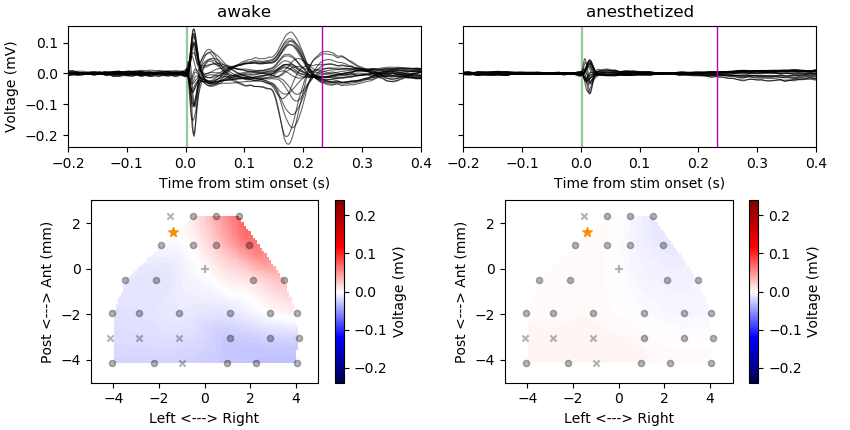

In [25]:
fig = plt.figure(figsize=(8.5, 4.3)) # 8.5, 4.3
gs = fig.add_gridspec(ncols=1, nrows=2, top=0.94, bottom=0.11, left=0.08, right=0.96, hspace=0.35, height_ratios=[2,3])
ylims = [np.min(minvolt)-0.01, np.max(maxvolt)+0.01]
vlim = np.max(np.abs(ylims))

initframe = 0

## butterfly plot ##
BFgs = gs[0].subgridspec(ncols=2, nrows=1, wspace=0.12)
BFaxs = [fig.add_subplot(ss) for ss in BFgs]
bflines = []
for bfax, traces in zip(BFaxs, butterfly_traces):
    bfax.axvspan(0, 0.002, color='g', alpha=0.3)
    bfax.plot(plot_time, traces, 'k', linewidth=0.8, alpha=0.6)
    bfline = bfax.axvline(x=EEGtime[frameinds[initframe]], color='m', linewidth=1)
    bfax.set_xlim(plwin)
    bfax.set_xlabel('Time from stim onset (s)')
    bfax.set_ylim(ylims)
    bflines.append(bfline)
BFaxs[0].set_ylabel('Voltage (mV)')
BFaxs[0].set_title('awake', fontsize=12)
BFaxs[1].set_title('anesthetized', fontsize=12)
BFaxs[1].set_yticklabels([])

## plot scatter plot heat map for time point ##
HMgs = gs[1].subgridspec(ncols=2, nrows=1, wspace=0.24)
HMaxs = [fig.add_subplot(ss) for ss in HMgs]
emaps = []
for hmax, state_interp in zip(HMaxs, interps):
    imeeg = hmax.imshow(
        state_interp[initframe,:,:],
        cmap='seismic', vmin=-vlim, vmax=vlim,
        origin='lower', interpolation='none',
        extent=(ml[0], ml[-1], ap[0], ap[-1]),
    )
    emaps.append(imeeg)
    hmax.scatter(
        EEGexp.EEG_channel_coordinates['ML'][GOOD_CHS], EEGexp.EEG_channel_coordinates['AP'][GOOD_CHS],
        c='k', alpha=0.3, marker='o', s=20
    )
    hmax.scatter(
        EEGexp.EEG_channel_coordinates['ML'][BAD_CHS], EEGexp.EEG_channel_coordinates['AP'][BAD_CHS],
        c='k', alpha=0.3, marker='x', s=20
    )
    hmax.scatter(0, 0, marker='+', color='k', s=30, alpha=0.3)
    hmax.scatter(-1.4, 1.6, marker='*', color='darkorange', s=50)
    hmax.set_ylabel('Post <---> Ant (mm)')
    hmax.set_xlabel('Left <---> Right')
    cb = fig.colorbar(imeeg, ax=hmax, fraction=0.2, aspect=20)
    cb.set_label('Voltage (mV)')
# hmax.set_title('Time: {:.3f} s'.format(timex[frameinds[initframe]]))

## animate function ##
def animate(i):
    for bfline, imeeg, state_interp in zip(bflines, emaps, interps):
        bfline.set_data([EEGtime[frameinds[i]], EEGtime[frameinds[i]]], [0,1])
        imeeg.set_data(state_interp[i,:,:])
#     hmax.set_title('Time: {:.3f} s'.format(timex[frameinds[i]]))

## animate it ##
anim = animation.FuncAnimation(fig, animate, init_func=None, frames=frameinds.shape[0], interval=300, blit=False)

movie_name = os.path.join(plotsdir, 'ERPmovie_{}bothstates_small_Q.mp4'.format(exmouse))
# anim.save(movie_name, writer='ffmpeg', fps=12, extra_args=['-vcodec', 'libx264'], dpi=500, bitrate=-1)

Plot for GRC poster blitz

<IPython.core.display.Javascript object>


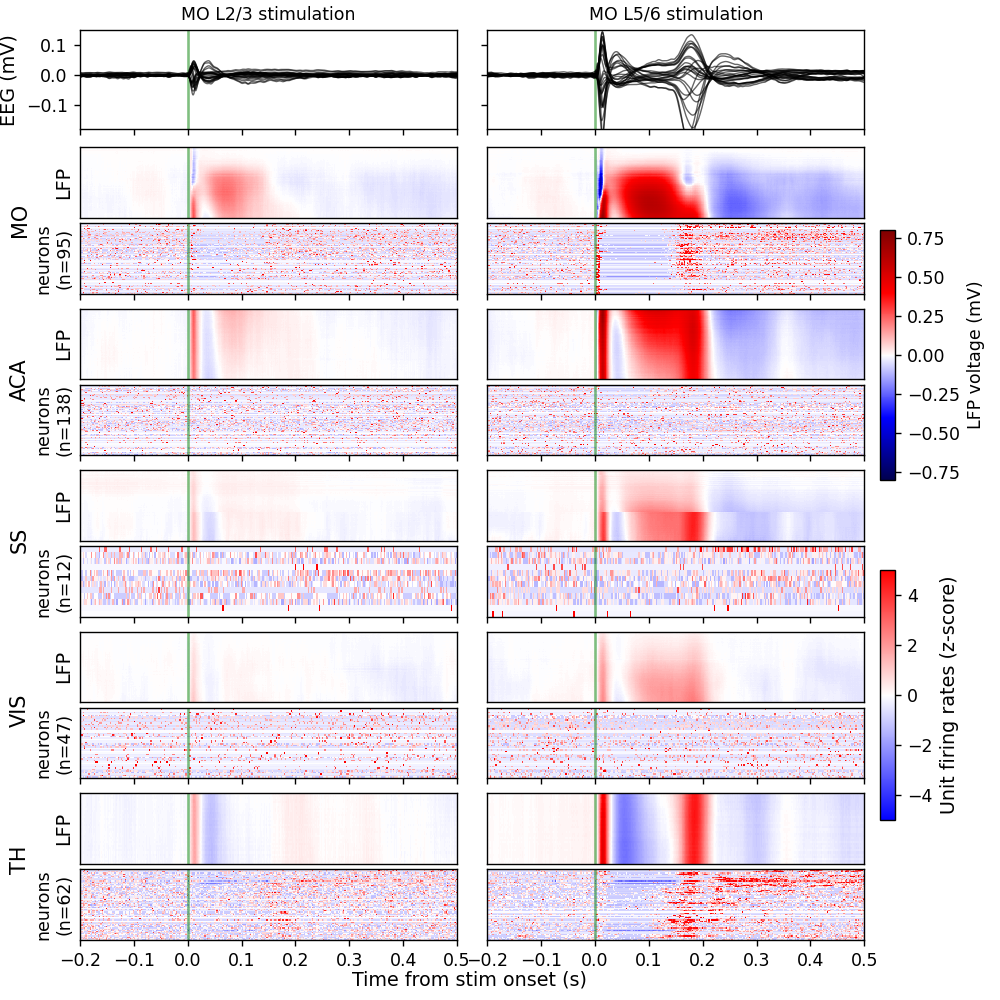

In [25]:
plwin = [-0.2, 0.5]
eeg_ylim = [-0.18, 0.15]
vlevel = 0.8
Zlim = 5
plevel = 'medium'

fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(
    ncols=2, nrows=2, height_ratios=[1, 8], width_ratios=[1, 0.02], left=0.08, right=0.9, top=0.97, bottom=0.06,
    wspace=0.05, hspace=0.04)
EEGaxs = gs[0,0].subgridspec(ncols=len(example_mice), nrows=1, wspace=0.08).subplots(sharex=True, sharey=True)
NPXgs = gs[1,0].subgridspec(ncols=len(example_mice), nrows=len(areas_of_interest), hspace=0.1, wspace=0.08)

for ii, (group, mouse) in enumerate(example_mice.items()):
    EEG_traces = ex_sub_dict[group][mouse]['data']['EEG'][plevel]
    LFP_traces = ex_sub_dict[group][mouse]['data']['LFP'][plevel]
    unitZ = ex_sub_dict[group][mouse]['data']['unit_zscores'][plevel]
    GOOD_CHS = ex_sub_dict[group][mouse]['good_chs']
    
    statei = 'resting'
    coli = ii
    ## Plot EEG traces ##
    EEGaxs[coli].axvline(0, color='g', alpha=0.5)
    EEGaxs[coli].plot(
        EEG_traces[statei][0], np.mean(EEG_traces[statei][1][:, GOOD_CHS, :], axis=2) / 1E3, 'k', linewidth=0.8, alpha=0.6)
    EEGaxs[coli].set_xlim(plwin)
    EEGaxs[coli].set_xticklabels([])
    EEGaxs[coli].set_ylim(eeg_ylim)
    if coli == 0:
        EEGaxs[coli].set_ylabel('EEG (mV)', fontsize=11)

    ## Plot unit z-score activity ##
    for kk, region in enumerate(areas_of_interest.keys()):
        if region not in unitZ[statei].keys():
            continue
        NPXaxs = NPXgs[kk,coli].subgridspec(nrows=2, ncols=1, hspace=0.08).subplots()
        ## LFP ##
        imlfp = NPXaxs[0].imshow(
            np.mean(LFP_traces[statei][region][1], axis=2).T / 1E3, cmap='seismic', #'bwr'
            interpolation='none', aspect='auto', origin='upper', vmin=-vlevel, vmax=vlevel,
            extent=[LFP_traces[statei][region][0][0], LFP_traces[statei][region][0][-1],
                    LFP_traces[statei][region][1].shape[1], 0]
        )
        NPXaxs[0].set_xlim(plwin)
        NPXaxs[0].axvline(0, color='g', alpha=0.5)
        NPXaxs[0].set_xticks([])
        NPXaxs[0].set_xticklabels([])
        NPXaxs[0].set_yticks([])
        ## Z-scores ##
        imunit = NPXaxs[1].imshow(
            unitZ[statei][region][1].T, cmap='bwr',
            interpolation='none', aspect='auto', origin='upper', vmin=-Zlim, vmax=Zlim,
            extent=[unitZ[statei][region][0][0], unitZ[statei][region][0][-1], 0, unitZ[statei][region][1].shape[0]],
        )
        NPXaxs[1].set_xlim(plwin)
        NPXaxs[1].axvline(0, color='g', alpha=0.5)
        if kk < len(areas_of_interest)-1:
            NPXaxs[1].set_xticklabels([])
        NPXaxs[1].set_yticks([])
        if coli == 0:
            NPXaxs[0].set_ylabel('LFP', fontsize=11)
            NPXaxs[1].set_ylabel('neurons\n(n={:d})'.format(unitZ[statei][region][1].shape[1]))#, fontsize=14)

fig.text(0.02, 0.78, 'MO', rotation='vertical', va='center', ha='center', fontsize=12)
fig.text(0.02, 0.62, 'ACA', rotation='vertical', va='center', ha='center', fontsize=12)
fig.text(0.02, 0.46, 'SS', rotation='vertical', va='center', ha='center', fontsize=12)
fig.text(0.02, 0.29, 'VIS', rotation='vertical', va='center', ha='center', fontsize=12)
fig.text(0.02, 0.14, 'TH', rotation='vertical', va='center', ha='center', fontsize=12)
                
fig.text(0.47, 0.02, 'Time from stim onset (s)', va='center', ha='center', fontsize=11)

EEGaxs[0].set_title('MO L2/3 stimulation')#, fontsize=16)
EEGaxs[1].set_title('MO L5/6 stimulation')#, fontsize=16)

## Add the colorbar ##
cbgs = gs[1,1].subgridspec(nrows=2, ncols=1, hspace=0.2)

lcbax = plt.subplot(cbgs[0], position=[0.88, 0.52, 0.015, 0.25])
lcb = Colorbar(ax=lcbax, mappable=imlfp, orientation='vertical', ticklocation='right')
lcb.set_label('LFP voltage (mV)')#, fontsize=14)

ucbax = plt.subplot(cbgs[1], position=[0.88, 0.18, 0.015, 0.25])
ucb = Colorbar(ax=ucbax, mappable=imunit, orientation='vertical', ticklocation='right')
ucb.set_label('Unit firing rates (z-score)', fontsize=11)

## Save ##
figname = 'evoked_EEG_LFP_unitZ_PB.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

<IPython.core.display.Javascript object>


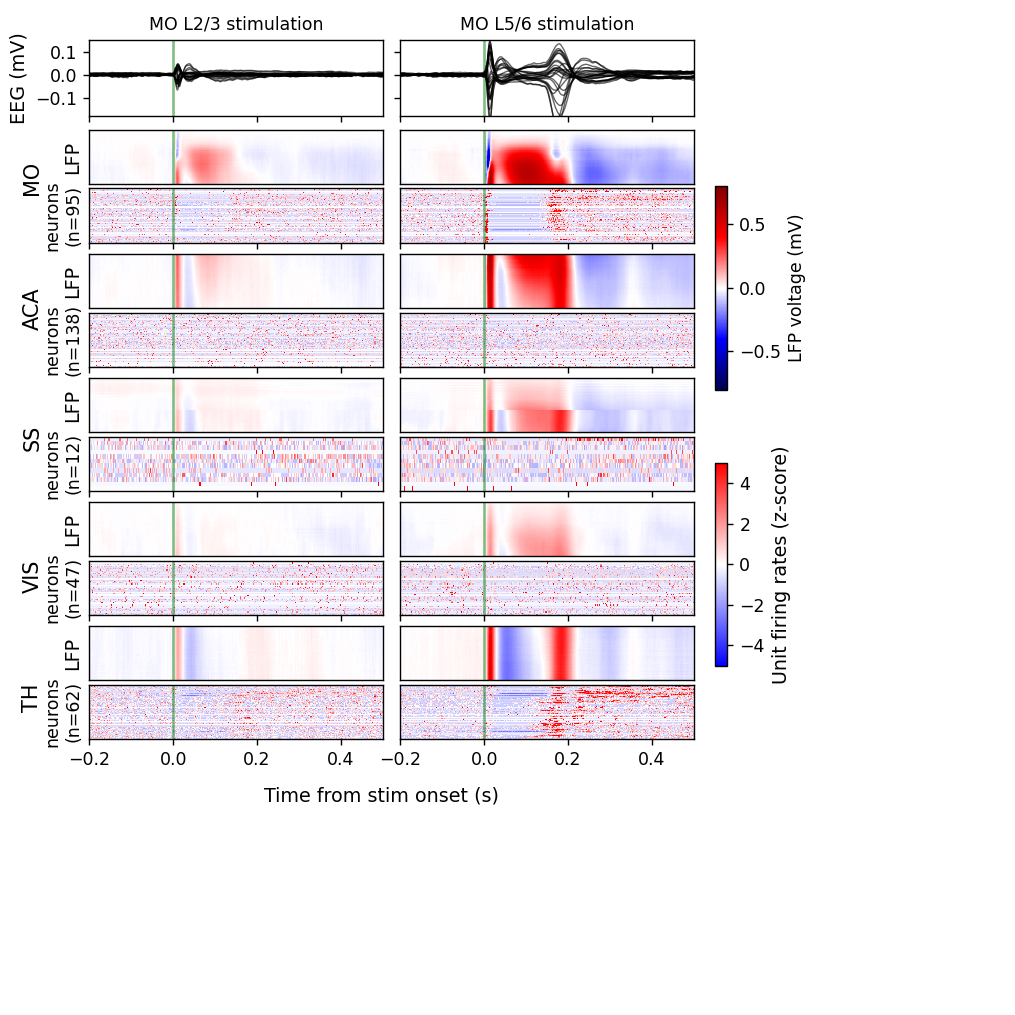

In [40]:
plwin = [-0.2, 0.5]
eeg_ylim = [-0.18, 0.15]
vlevel = 0.8
Zlim = 5
plevel = 'medium'

fig = plt.figure(figsize=(6.5, 6.5))
gs = fig.add_gridspec(
    ncols=2, nrows=2, height_ratios=[1, 8], width_ratios=[1, 0.02], left=0.11, right=0.88, top=0.95, bottom=0.09,
    wspace=0.03, hspace=0.04)
EEGaxs = gs[0,0].subgridspec(ncols=len(example_mice), nrows=1, wspace=0.06).subplots(sharex=True, sharey=True)
NPXgs = gs[1,0].subgridspec(ncols=len(example_mice), nrows=len(areas_of_interest), hspace=0.1, wspace=0.06)

for ii, (group, mouse) in enumerate(example_mice.items()):
    EEG_traces = ex_sub_dict[group][mouse]['data']['EEG'][plevel]
    LFP_traces = ex_sub_dict[group][mouse]['data']['LFP'][plevel]
    unitZ = ex_sub_dict[group][mouse]['data']['unit_zscores'][plevel]
    GOOD_CHS = ex_sub_dict[group][mouse]['good_chs']
    
    statei = 'resting'
    coli = ii
    ## Plot EEG traces ##
    EEGaxs[coli].axvline(0, color='g', alpha=0.5)
    EEGaxs[coli].plot(
        EEG_traces[statei][0], np.mean(EEG_traces[statei][1][:, GOOD_CHS, :], axis=2) / 1E3, 'k', linewidth=0.8, alpha=0.6)
    EEGaxs[coli].set_xlim(plwin)
    EEGaxs[coli].set_xticklabels([])
    EEGaxs[coli].set_ylim(eeg_ylim)
    if coli == 0:
        EEGaxs[coli].set_ylabel('EEG (mV)', fontsize=11)

    ## Plot unit z-score activity ##
    for kk, region in enumerate(areas_of_interest.keys()):
        if region not in unitZ[statei].keys():
            continue
        NPXaxs = NPXgs[kk,coli].subgridspec(nrows=2, ncols=1, hspace=0.08).subplots()
        ## LFP ##
        imlfp = NPXaxs[0].imshow(
            np.mean(LFP_traces[statei][region][1], axis=2).T / 1E3, cmap='seismic', #'bwr'
            interpolation='none', aspect='auto', origin='upper', vmin=-vlevel, vmax=vlevel,
            extent=[LFP_traces[statei][region][0][0], LFP_traces[statei][region][0][-1],
                    LFP_traces[statei][region][1].shape[1], 0]
        )
        NPXaxs[0].set_xlim(plwin)
        NPXaxs[0].axvline(0, color='g', alpha=0.5)
        NPXaxs[0].set_xticks([])
        NPXaxs[0].set_xticklabels([])
        NPXaxs[0].set_yticks([])
        ## Z-scores ##
        imunit = NPXaxs[1].imshow(
            unitZ[statei][region][1].T, cmap='bwr',
            interpolation='none', aspect='auto', origin='upper', vmin=-Zlim, vmax=Zlim,
            extent=[unitZ[statei][region][0][0], unitZ[statei][region][0][-1], 0, unitZ[statei][region][1].shape[0]],
        )
        NPXaxs[1].set_xlim(plwin)
        NPXaxs[1].axvline(0, color='g', alpha=0.5)
        if kk < len(areas_of_interest)-1:
            NPXaxs[1].set_xticklabels([])
        NPXaxs[1].set_yticks([])
        if coli == 0:
            NPXaxs[0].set_ylabel('LFP', fontsize=11)
            NPXaxs[1].set_ylabel('neurons\n(n={:d})'.format(unitZ[statei][region][1].shape[1]))#, fontsize=14)

fig.text(0.04, 0.78, 'MO', rotation='vertical', va='center', ha='center', fontsize=12)
fig.text(0.04, 0.62, 'ACA', rotation='vertical', va='center', ha='center', fontsize=12)
fig.text(0.04, 0.46, 'SS', rotation='vertical', va='center', ha='center', fontsize=12)
fig.text(0.04, 0.29, 'VIS', rotation='vertical', va='center', ha='center', fontsize=12)
fig.text(0.04, 0.14, 'TH', rotation='vertical', va='center', ha='center', fontsize=12)
                
fig.text(0.47, 0.02, 'Time from stim onset (s)', va='center', ha='center', fontsize=11)

EEGaxs[0].set_title('MO L2/3 stimulation')#, fontsize=16)
EEGaxs[1].set_title('MO L5/6 stimulation')#, fontsize=16)

## Add the colorbar ##
cbgs = gs[1,1].subgridspec(nrows=2, ncols=1, hspace=0.2)

lcbax = plt.subplot(cbgs[0], position=[0.88, 0.52, 0.015, 0.25])
lcb = Colorbar(ax=lcbax, mappable=imlfp, orientation='vertical', ticklocation='right')
lcb.set_label('LFP voltage (mV)')#, fontsize=14)

ucbax = plt.subplot(cbgs[1], position=[0.88, 0.18, 0.015, 0.25])
ucb = Colorbar(ax=ucbax, mappable=imunit, orientation='vertical', ticklocation='right')
ucb.set_label('Unit firing rates (z-score)', fontsize=11)

## Save ##
figname = 'evoked_EEG_LFP_unitZ_PB.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

### Plot two subjects examples with EEG and unit zscores for awake and anesthetized